# Demo session: Applications of H SAF products, including tools for downloading, processing and visualization of data
## Flood modelling with satellite rainfall data in Africa
## Christian Massari & Sara Modanesi

# Impact of precipitation input on river discharge simulation

The exercise is divided in four different steps:
1) We will calibrate the MILc rainfall-runoff model (lumped version of the MISDc) over a basin in Africa using the GPCC rainfall product. For the calibration we will use the Particle Swarm Optimization algorithm, optimizing the KGE.
2) We will run the MILc over the basin using the calibrated parameters with GPCC and different rainfall products as inputs;
3) We will calibrate the model using the different rainfall products;
4) The model will run again using the calibrated parameters and the best performing rainfall product will be identified.

In particular, rainfall products used will be: 
* GPCC Global Precipitation Climatology Centre product for the initial calibration;
* ERA-5 reanlysis product;
* SM2RAIN product;
* H64 product;
* H23 product.

All the data are stored in different text files and are named considering the different rainfall products.

The cathcment is located in South Africa where rain gauge observations are pretty denser than in other African countries

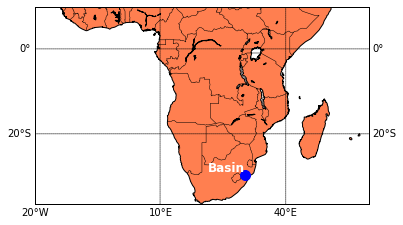


### Import the necessary python libraries

In [25]:
from MILc_2 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history


# Let's take a look to the rainfall and discharge time series

In [11]:
name1='AFRICA_GPCC_2011_14'
data_input1=pd.read_csv(name1+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)
Ab=340 #area of the basin
data_input1.head()

,P,T,Q
2011-01-01,1.7496,20.32,3.712
2011-01-02,8.1949,22.47,5.328
2011-01-03,10.8695,17.85,5.788
2011-01-04,14.7804,17.37,6.166
2011-01-05,8.4735,18.07,8.940


Text(0.5, 1.0, 'GPCC Rainfall')

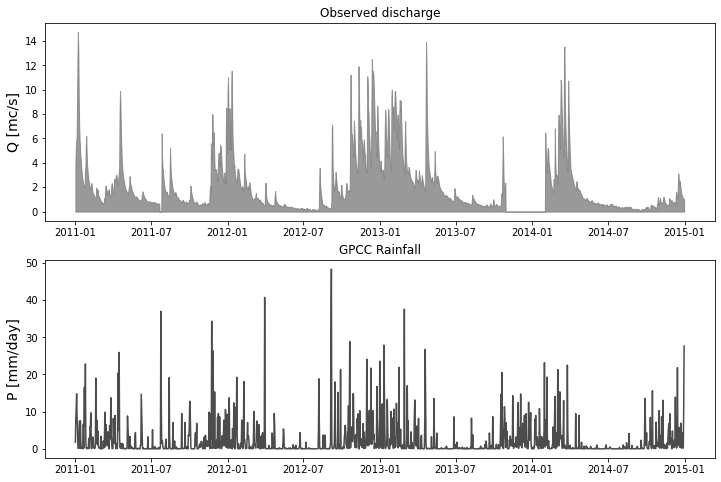

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.fill_between(data_input1.index,data_input1['Q'].values,0,color='gray',alpha=0.8)
plt.title('Observed discharge')
plt.ylabel('Q [mc/s]', fontsize=14)
plt.subplot(212)
plt.plot(data_input1['P'],alpha=0.7,color='black')
plt.ylabel('P [mm/day]', fontsize=14)
plt.title('GPCC Rainfall')

# STEP1: calibration of the MISDc rainfall-runoff model over a basin in Africa using the GPCC rainfall product

## Model calibration with Pyswarm optimization tool (PSO)

see the documentation and installation at https://pypi.org/project/pyswarms/0.1.9/

PSO https://link.springer.com/article/10.1007/s00500-016-2474-6

We are going to calibrate 8 model parameters: https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.8042

1) Initial conditions, fraction of W_max (0-1);

2) Field capacity;

3) Exponent of drainage;

4) Parameter of infiltration and drainage;

5) Fraction of drainage verusu interflow;

6) Coefficient lag-time relationship;

7) Parameter of potential evapotranspiration;

8) Runoff exponent.

Hydrological Model code can be found here http://hydrology.irpi.cnr.it/download-area/midsc-code/ and here https://github.com/IRPIhydrology/MISDc

2022-01-25 12:55:51,397 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|20/20, best_cost=0.272
2022-01-25 12:55:58,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.27161948017541127, best pos: [4.50931169e-01 4.78667637e+02 5.73606663e+00 3.99680209e+00
 1.18219085e-01 1.92291731e+00 1.67205973e+00 5.59370660e+00]


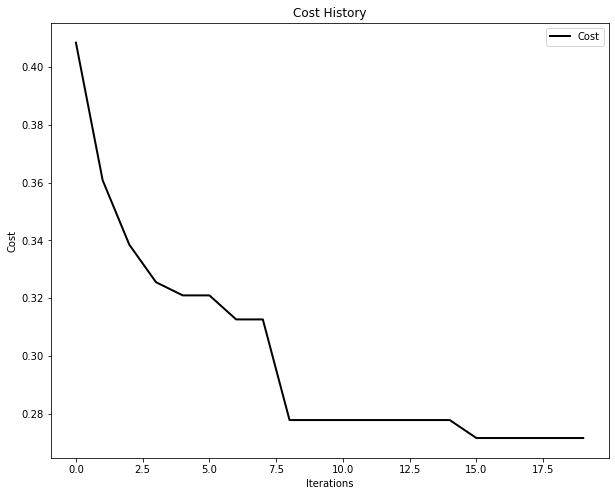

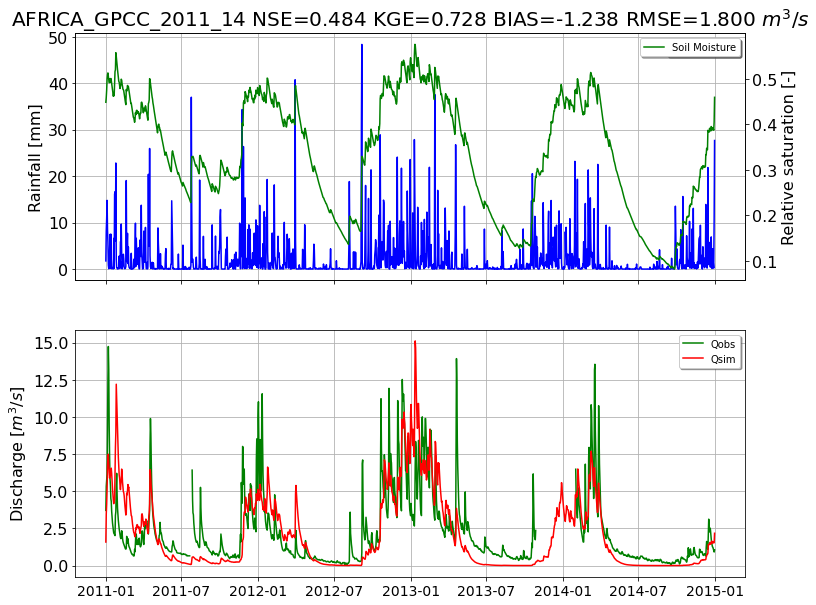

In [14]:
#Define the KGE objective function
def func(PARv):
    #global d_input, Ab
    n_particles = PARv.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        KGE,data=MILC(name,d_input,PARv[i],Ab,Wobs=[],K=0,fig=0)
        err[i] = 1 - KGE
    return err

#PSO needs defined parameters boundaries. 
bnds1 = (np.array([0, 200, 1, 0,
                          0, 0.5, 1, 1]),
                np.array([1, 1000, 10, 5,
                          1, 3, 2, 15]))
#PSO needs defined options
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} #https://link.springer.com/article/10.1007/s00500-016-2474-6

#Call instance of PSO with bounds argument
name=name1 #variables renamed to be used in the objective function
d_input=data_input1 #input from GPCC becomes the input for the objective function
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=8, options=options, bounds=bnds1)
cost, pos = optimizer.optimize(func, 20)

#Obtain cost history from optimizer instance
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()
PARn = pos
np.savetxt('X_opt_' + name+'.txt', PARn) #save parameters calibrated for GPCC input
PAR=np.loadtxt('X_opt_' + name+'.txt') #Calibrated parameters with GPCC input
QobsQsim,data=MILC(name1,data_input1,PAR,Ab,fig=1)

### The figure shows, in the upper plot, relative saturation and rainfall. In the bottom plot the temporal comparison between observed and simulated river discharge is shown. The scores are displayed in the title. We obtain a satisfactory KGE of 0.73 with the calibrated parameters considering the entire calibration period

# STEP2: running the rainfall-runoff model with GPCC-calibrated parameters considering different precipitation inputs
## Model run using GPCC-calibrated parameters and input precipitation from ERA-5 rainfall dataset

The figure shows, in the upper plot, relative saturation and rainfall. In the bottom plot the temporal comparison between observed and simulated river discharge is shown. The scores are displayed in the title. We obtain a satisfactory KGE of 0.73 with the calibrated parameters considering the entire calibration period 

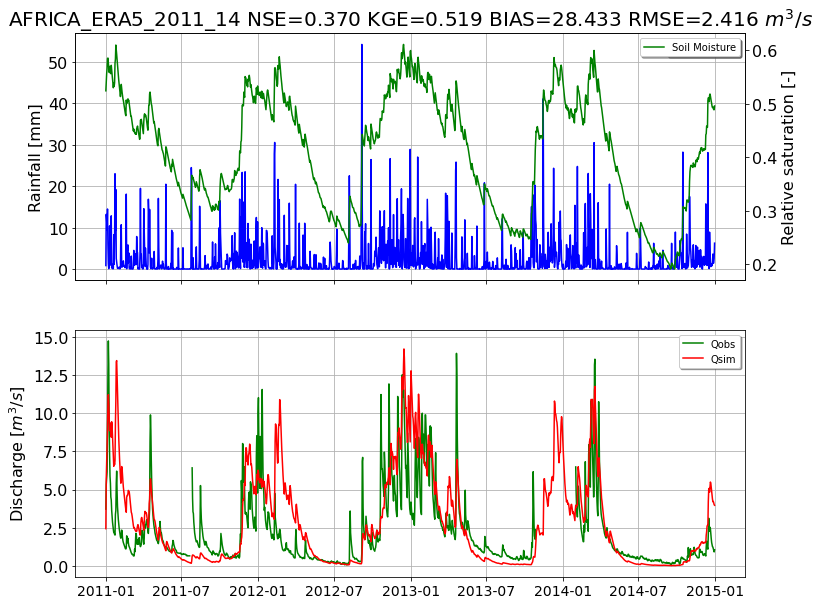

In [5]:
name2='AFRICA_ERA5_2011_14'
data_input2=pd.read_csv(name2+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)

QobsQsim,data=MILC(name2,data_input2,PAR,Ab,fig=1) #Parameters have been calibrated using GPCC

### In the bottom plot we obtain a KGE of 0.5 between observed and simulated river discharge using the parameters calibrated with GPCC. Performances are lower but acceptable. However we see that we have lower performance with with respect to those obtained with GPCC.

### Model run using GPCC-calibrated parameters and input precipitation from SM2RAIN rainfall dataset

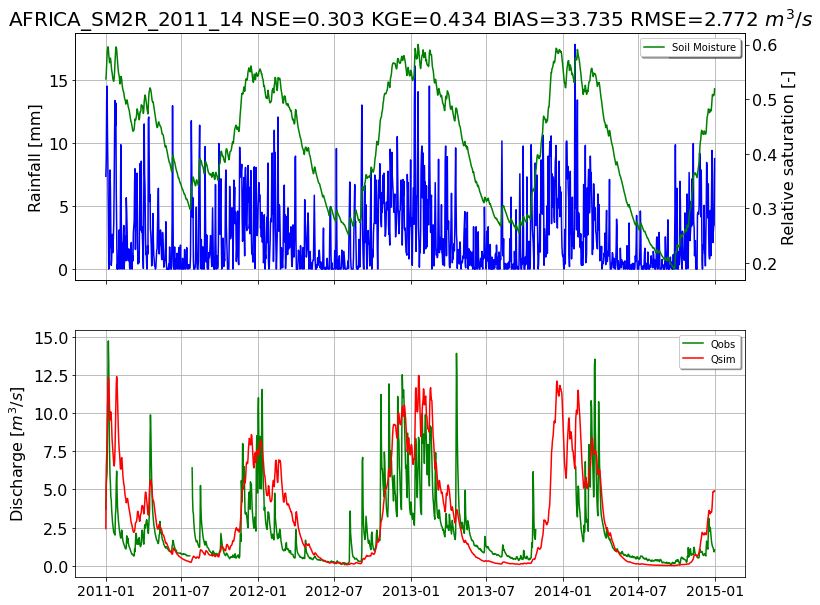

In [6]:
name3='AFRICA_SM2R_2011_14'
data_input3=pd.read_csv(name3+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)

QobsQsim,data=MILC(name3,data_input3,PAR,Ab,fig=1) #Parameters calibrated using GPCC

### Model run using GPCC-calibrated parameters and input precipitation from GPM rainfall dataset

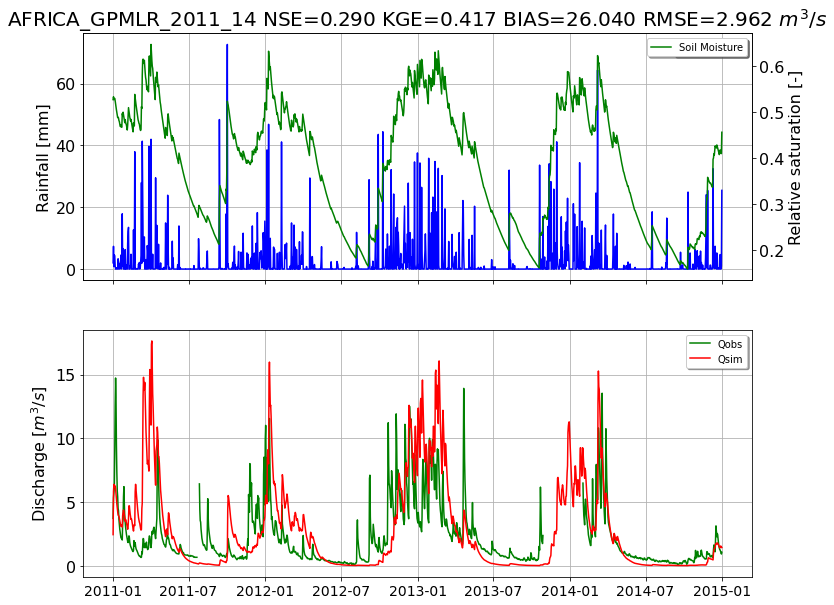

In [7]:
name4='AFRICA_GPMLR_2011_14'
data_input4=pd.read_csv(name4+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)

QobsQsim,data=MILC(name4,data_input4,PAR,Ab,fig=1)

### Model run using GPCC-calibrated parameters and input precipitation from H23 rainfall dataset 

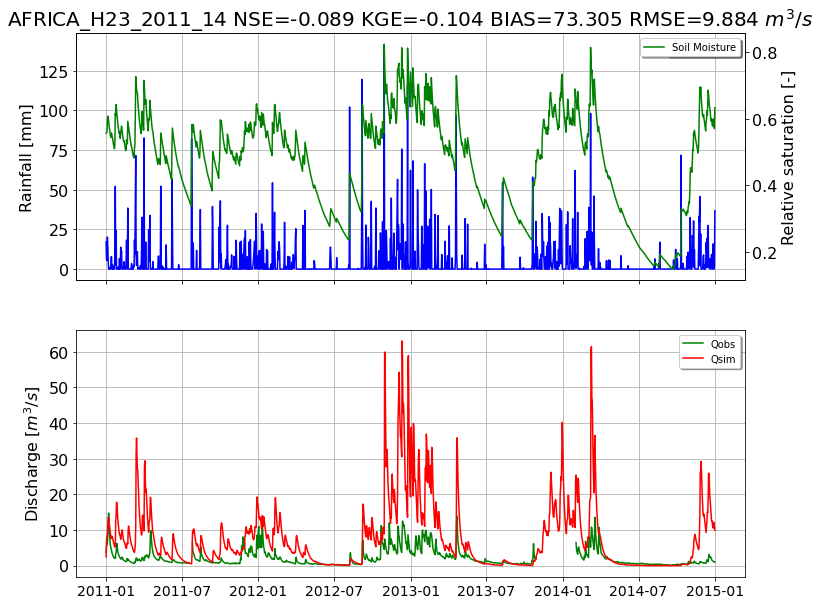

In [9]:
name6='AFRICA_H23_2011_14'
data_input6=pd.read_csv(name6+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)

QobsQsim,data=MILC(name6,data_input6,PAR,Ab,fig=1)

### The H23 product shows the lower performances compared with the previous products using the GPCC calibrated parameters 

## Let's control what leads to the poor performance of H23 rainfall product



Corr =  0.639  Multiplicative Bias [%]= 206.08


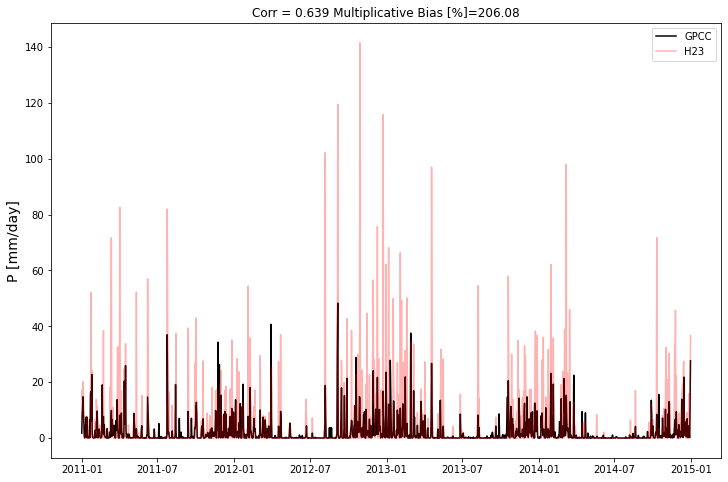

In [15]:
name1='AFRICA_GPCC_2011_14'
data_GPCC=pd.read_csv(name1+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)
name2='AFRICA_H23_2011_14'
data_H23=pd.read_csv(name2+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)


data_GPCC_H23=pd.concat([data_GPCC['P'],data_H23['P']],axis=1)
data_GPCC_H23.columns = ['GPCC', 'H23']
data_GPCC_H23.head()

Corr=data_GPCC_H23['GPCC'].corr(data_GPCC_H23['H23'])
Bias=data_GPCC_H23['H23'].mean()/data_GPCC_H23['GPCC'].mean()*100
print('Corr = ',np.round(Corr,3),' Multiplicative Bias [%]=',np.round(Bias,2))

plt.figure(figsize=(12,8))
plt.plot(data_GPCC['P'],alpha=1,color='black')
plt.title('Observed discharge')
plt.ylabel('P [mc/s]', fontsize=14)
plt.plot(data_H23['P'],alpha=0.3,color='red')
plt.ylabel('P [mm/day]', fontsize=14)
plt.title('Corr = '+str(np.round(Corr,3))+' Multiplicative Bias [%]='+str(np.round(Bias,2)))
plt.legend(('GPCC','H23'))

### So bias seems the main driver of the poor model simulation...


## Step 3: we might try to correct its bias and re-run the model with the bias corrected product


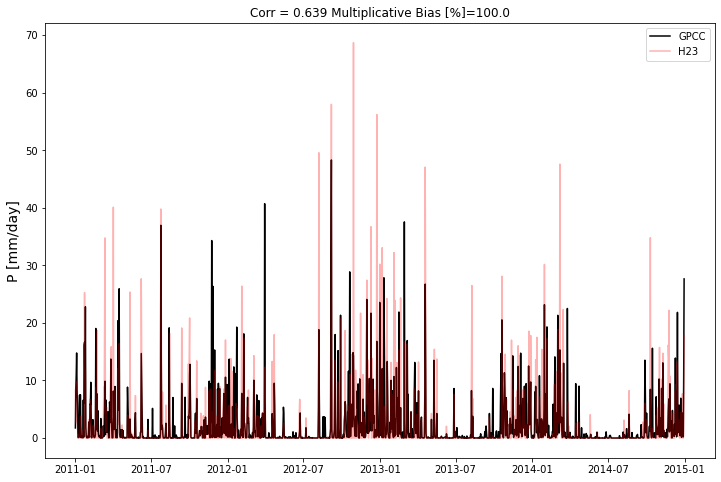

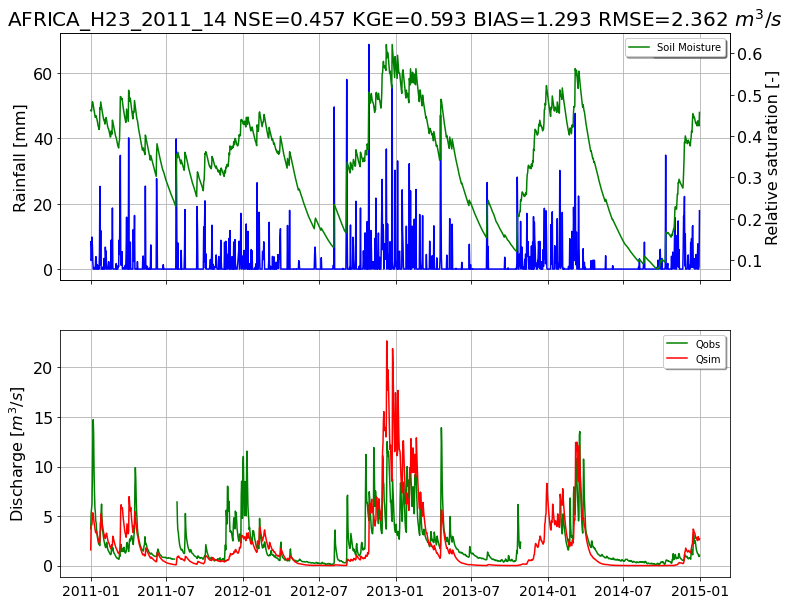

In [17]:
alpha=data_GPCC_H23['H23'].mean()/data_GPCC_H23['GPCC'].mean() # ratio of means of the two products 
data_GPCC_H23['H23']=data_GPCC_H23['H23']*(1/alpha)

Bias=data_GPCC_H23['H23'].mean()/data_GPCC_H23['GPCC'].mean()*100

plt.figure(figsize=(12,8))
plt.plot(data_GPCC['P'],alpha=1,color='black')
plt.title('Observed discharge')
plt.ylabel('P [mc/s]', fontsize=14)
plt.plot(data_GPCC_H23['H23'],alpha=0.3,color='red')
plt.ylabel('P [mm/day]', fontsize=14)
plt.title('Corr = '+str(np.round(Corr,3))+' Multiplicative Bias [%]='+str(np.round(Bias,2)))
plt.legend(('GPCC','H23'))

data_H23['P']=data_GPCC_H23['H23'].values

QobsQsim,data=MILC(name6,data_H23,PAR,Ab,fig=1)

### Correcting the bias of the rainfall is effective!! But let's see if recalibration is better...


2022-01-25 14:40:23,328 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|20/20, best_cost=0.301
2022-01-25 14:40:30,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30112159177956577, best pos: [  0.79069774 771.82673203   5.16001441   3.16317486   0.8148999
   1.09677686   1.27464632  10.8734559 ]


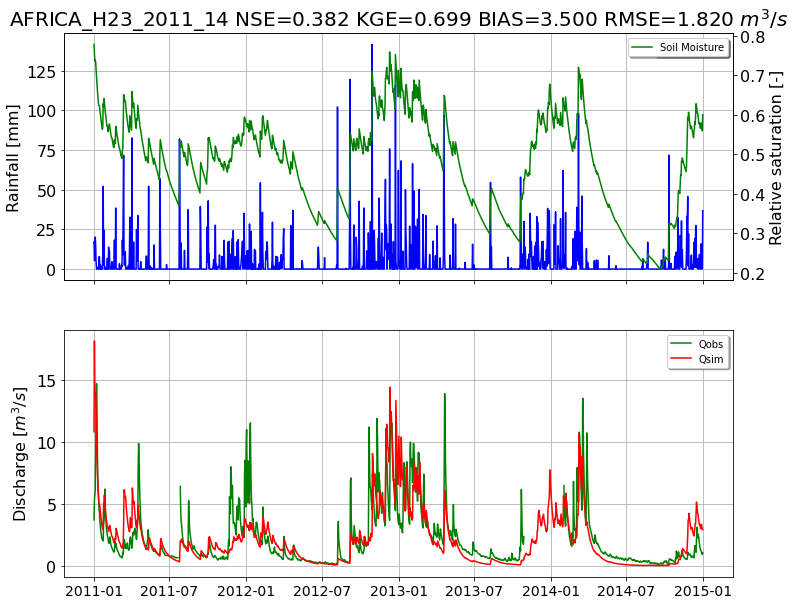

In [29]:
#The objective function and pso options have been previously defined

#Call instance of PSO with bounds argument
name=name6
d_input=data_input6 #input from H23 becomes the input for the objective function
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=8, options=options, bounds=bnds1)
cost, pos = optimizer.optimize(func, 20)

#Obtain cost history from optimizer instance
#plot_cost_history(cost_history=optimizer.cost_history)
#plt.show()
PARn = pos
np.savetxt('X_opt_' + name+'.txt', PARn) #save parameters calibrated for H23 input

PAR6=np.loadtxt('X_opt_' + name6+'.txt') #Calibrated parameters with GPM input
QobsQsim,data=MILC(name6,data_input6,PAR6,Ab,fig=1)

### Results are now even better...

## Is this true also for SM2RAIN and ERA5? Does recalibration improve the performance?


2022-01-25 14:37:48,547 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|20/20, best_cost=0.368
2022-01-25 14:37:55,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.36785507342990087, best pos: [6.62475919e-01 3.98330845e+02 4.68273250e+00 8.87699562e-01
 3.31040106e-01 2.69843611e+00 1.67582091e+00 6.45975139e+00]
2022-01-25 14:37:56,217 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|20/20, best_cost=0.317
2022-01-25 14:38:03,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3169809224630118, best pos: [6.32537503e-01 6.80382190e+02 7.52922875e+00 3.75390455e+00
 4.38870626e-01 2.33991924e+00 1.17155140e+00 7.26886842e+00]


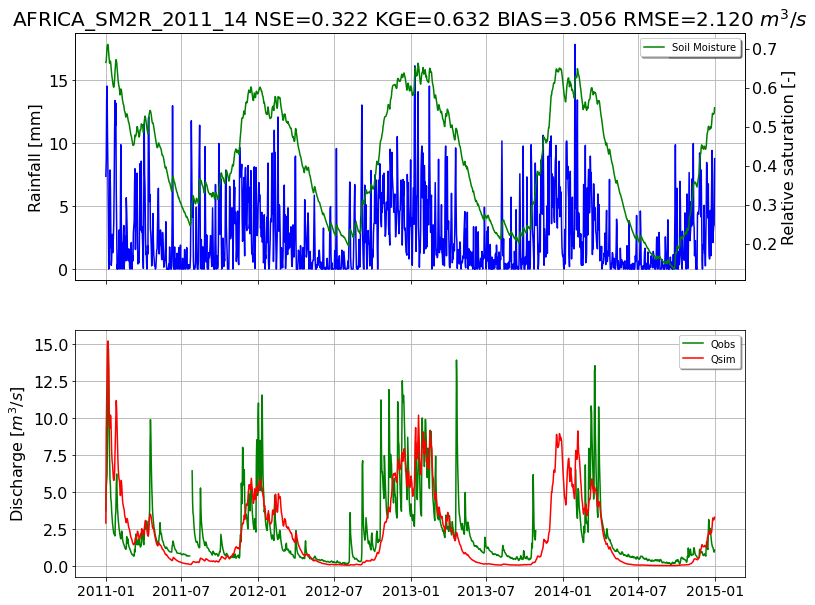

In [27]:
#The objective function and pso options have been previously defined

#Call instance of PSO with bounds argument
name=name3
d_input=data_input3 #input from SM2RAIN becomes the input for the objective function
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=8, options=options, bounds=bnds1)
cost, pos = optimizer.optimize(func, 20)

#Obtain cost history from optimizer instance
#plot_cost_history(cost_history=optimizer.cost_history)
#plt.show()
PARn = pos
np.savetxt('X_opt_' + name+'.txt', PARn) #save parameters calibrated for SM2RAIN input
PAR3=np.loadtxt('X_opt_' + name3+'.txt') #Calibrated parameters with SM2RAIN input
QobsQsim,data=MILC(name3,data_input3,PAR3,Ab,fig=1)

## ERA5

#Call instance of PSO with bounds argument
name=name2
d_input=data_input2 #input from ERA-5 becomes the input for the objective function
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=8, options=options, bounds=bnds1)
cost, pos = optimizer.optimize(func, 20)

#Obtain cost history from optimizer instance
#plot_cost_history(cost_history=optimizer.cost_history)
#plt.show()
PARn = pos
np.savetxt('X_opt_' + name+'.txt', PARn) #save parameters calibrated for ERA-5 input
PAR2=np.loadtxt('X_opt_' + name2+'.txt') #Calibrated parameters with ERA-5 input
QobsQsim,data=MILC(name2,data_input2,PAR2,Ab,fig=1)

### Yes, recalibration boost the performance of the model as parameters are able to take into account of the bias of the the rainfall observations


## Step 4: What about integrating SM2RAIN and H23? Let's calibrate with H64 product...


2022-01-25 14:39:56,343 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|20/20, best_cost=0.289
2022-01-25 14:40:03,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2890786424207835, best pos: [  0.64063023 492.91088442   5.80546142   2.98714032   0.65959044
   2.17240862   1.55906755  12.43263162]


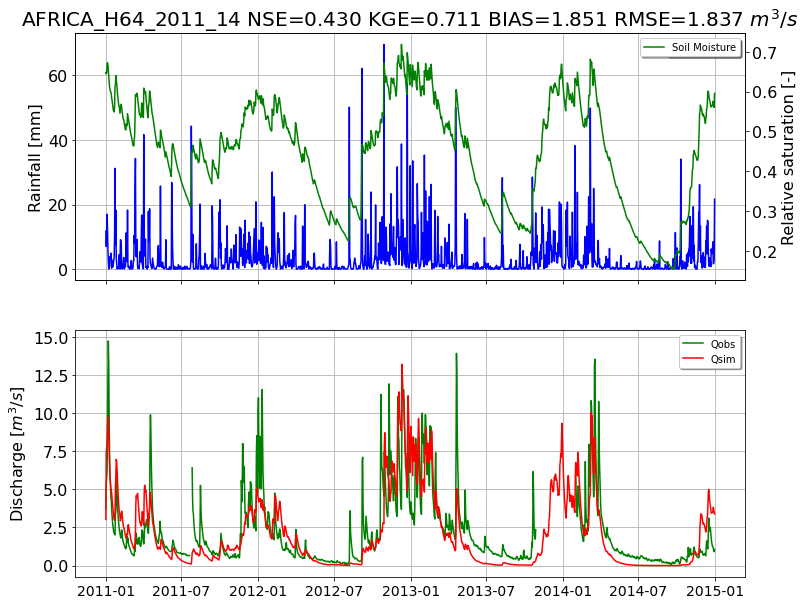

In [28]:
#The objective function and pso options have been previously defined

name5='AFRICA_H64_2011_14'
data_input5=pd.read_csv(name5+'.txt',index_col=0,header = None, names = ['P','T','Q'],sep=',',parse_dates=True)

#Call instance of PSO with bounds argument
name=name5
d_input=data_input5 #input from H64 becomes the input for the objective function
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=8, options=options, bounds=bnds1)
cost, pos = optimizer.optimize(func, 20)

#Obtain cost history from optimizer instance
#plot_cost_history(cost_history=optimizer.cost_history)
#plt.show()
PARn = pos
np.savetxt('X_opt_' + name+'.txt', PARn) #save parameters calibrated for H64 input
PAR5=np.loadtxt('X_opt_' + name5+'.txt') #Calibrated parameters with GPM input
QobsQsim,data=MILC(name5,data_input5,PAR5,Ab,fig=1)

### We obtain really good results very close to GPCC performance

# Summary

| RAINFALL PRODUCT | KGE WITH GPCC CAL PARAM. | Mult. BIAS CORRECTION (GPCC) | (RE)CALIBRATION
| --- | --- | --- | -- |
| GPCC |   |  | 0.734 |
| ERA5 | 0.519 | -- | 0.672 |
| SM2R | 0.434 | -- | 0.647 |
| H23 | -0.105 | 0.593 |0.699 |
| H64 | 0.123 | -- | 0.722 |


### Well, in this basin H64 is even better than ERA5. So are H-SAF rainfall products useful? YES THEY ARE! You might try to complete the table by adjusting the bias of the rainfall product as in Step 2



## Lab done!!!